Notes:
For next meeting:

Pymer4 lmer won't run! --> solution code in R --> how to implement it?
Prorblem: inverse gausian or gamma won't take non-positive values (they're present in data)
can't make function out of GLMER due to family arguement (can't be tranfered into function)
--> maybe run models outside functions? But how do we specify the family?

Do we trust equal varriance to be enough to not add mixed effects? Ask statistician!

In [1]:
import sys
sys.path.append('/Users/Sofie/Documents/DCL/DCLmeetsRETUNE/image_analysis_pipeline/')

In [2]:
from findmycells.main import Project
from findmycells.quantifications import ReconstructCellsIn3DFrom2DInstanceLabels, CountCellsInWholeStructure
#from findmycells.inspection import InspectUsingMultiMatchIDX

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from pingouin import kruskal, read_dataset
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy
#from statsmodels import qqplot
import statsmodels.formula.api as smf
#from statsmodels.formula.api import MixedLM
from scipy.stats import norm, levene, bartlett
import statistics
import statsmodels.api as sm
from fitter import Fitter, get_common_distributions, get_distributions
from pymer4.models import Lm, Lmer
import pymer4
import rpy2

## Load and Prepare the Data

In [5]:
df = pd.read_csv('counted_cells.csv')

In [5]:
df.tail(10)

,Unnamed: 0,file_id,group_id,subject_id,analyzed_area,total_planes,connected_components,cc_normalized_per_area,cc_normalized_per_volume
51,51,54,wt,#7_wt_old,8767360.0,9.0,86.0,130.837103,14.537456
52,52,55,wt,#7_wt_old,5892928.0,8.0,12.0,27.161354,3.395169
53,53,56,wt,#7_wt_old,4314688.0,9.0,70.0,216.396361,24.044040
54,54,57,wt,#9_wt_old,5140832.0,8.0,46.0,119.350909,14.918864
55,55,58,wt,#9_wt_old,4477600.0,8.0,71.0,211.501944,26.437743
56,56,59,wt,#9_wt_old,7410528.0,9.0,184.0,331.184482,36.798276
57,57,60,wt,#9_wt_old,7109728.0,10.0,152.0,285.162170,28.516217
58,58,61,wt,#9_wt_old,5770116.0,9.0,123.0,284.329471,31.592163
59,59,62,wt,#9_wt_old,5751712.0,9.0,86.0,199.435575,22.159508
60,60,63,wt,#9_wt_old,4715968.0,10.0,96.0,271.519917,27.151992


## Let's check normality

In [20]:
stat_results = dict()

In [21]:
from typing import Dict, List, Tuple

def check_normality(data: pd.DataFrame, dv_col: str, results: Dict) -> Dict:
    stat, p = shapiro(data[dv_col])
    if p >= 0.05:
        normal = True
    else:
        normal = False
    stat_results['normal_distribution'] = {'test_statistic': stat, 'p-value': p, 'bool': normal}
    return stat_results

In [22]:
#test it runs
check_normality(df, 'cc_normalized_per_volume', results)

{'normal_distribution': {'test_statistic': 0.9805209636688232,
  'p-value': 0.43962615728378296,
  'bool': True}}

### Equal varriance testing function

In [24]:
def equal_variance_test(data: pd.DataFrame, dv_col: str, iv_col: str, stat_results: Dict) -> Dict:
    #note that in iv_col we NEED items to be called 'tg' and 'wt' --> how to work around? we just need to seperate based on level
    
    #Make dataframes compatible for Levene's and Bartlett's test
    df_tg = data.loc[data[iv_col] == 'tg']
    df_tg = df_tg.rename(columns={dv_col: "tg"})

    df_wt = data.loc[data[iv_col] == 'wt']
    df_wt = df_wt.rename(columns={dv_col: "wt"})

    #use levene on non-normal data and Bartels on normal data to test equal varriance
    if stat_results['normal_distribution']['bool'] == False: #non-normal data
        stat, p_homo = levene(df_wt['wt'], df_tg['tg'])
        if p_homo >= 0.05:
            normal = True
            stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
        elif p_homo < 0.05:
            normal = False
            stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
    elif stat_results['normal_distribution']['bool'] == True: #normal data
        stat, p_homo = bartlett(df_wt['wt'], df_tg['tg'])
        if p_homo >= 0.05:
            normal = True
            stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
        elif p_homo < 0.05:
            normal = False
            stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
    else: print('Normality not assessed yet. Please complete normality test before proceeding')
    return stat_results

In [25]:
#test that it works
equal_variance_test(df, "cc_normalized_per_volume", "group_id", stat_results)

{'normal_distribution': {'test_statistic': 0.9805209636688232,
  'p-value': 0.43962615728378296,
  'bool': True},
 'fixed_effects_equal_varriance': {'test_statistic': 1.008462065676145,
  'p-value': 0.31527156257040106,
  'bool': True}}

## Non-parametic function - Kruskal-Wallis H-test

In [7]:
#make it a function for no equal varriance
def non_par_inequal_var(data: pd.DataFrame, dv_col: str, iv_col: str, subject: str):
    #Aggregate the data across subjects
    df_nonpar = df.groupby([subject, iv_col], as_index=False)[dv_col].mean()
    #run non-par model
    non_par_inequal_var = kruskal(data=df_nonpar, dv=dv_col, between=iv_col)
    return non_par_inequal_var

#make it a function for equal varriance
def non_par_equal_var(data: pd.DataFrame, dv_col: str, iv_col: str,):
    #run non-par model
    non_par_equal_var = kruskal(data=df_nonpar, dv=dv_col, between=iv_col)
    return non_par_equal_var


### Define plot for equal varriance

In [212]:
def plot_fixed_effect_varriance(data: pd.DataFrame, dv_col: str, fixed_effects_col: str, random_effects_col: str) -> plt:
    fig = plt.figure(figsize=(10,12), facecolor='white')
    gs = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gs[0,0])
    sns.violinplot(data = data[data[fixed_effects_col] == 'wt'], x=random_effects_col, y=dv_col, ax = ax1)
    ax2 = fig.add_subplot(gs[1,0])
    sns.violinplot(data = data[data[fixed_effects_col] == 'tg'], x=random_effects_col, y=dv_col, ax = ax2)
    plt.show()

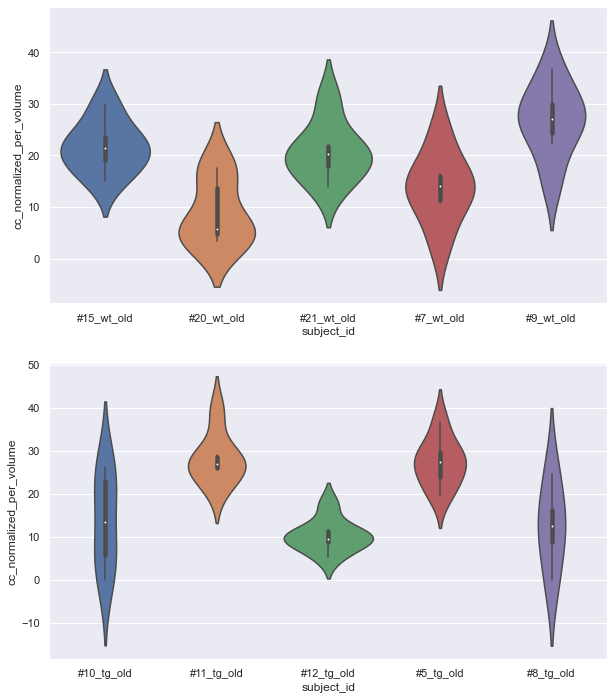

In [213]:
#test it runs
plot_fixed_effect_varriance(data = df, dv_col = 'cc_normalized_per_volume', fixed_effects_col = 'group_id', random_effects_col = 'subject_id')

### Define fitter plot

In [31]:
def visualize_distributions(data: pd.DataFrame, dv_col: str, distributions: list):
    f = Fitter(data[dv_col], distributions=distributions)
    f.fit()
    return f.summary()


,sumsquare_error,aic,bic,kl_div
norm,0.088308,780.197966,-390.583766,inf
gamma,0.088521,781.830249,-386.326211,inf
lognorm,0.090317,784.101266,-385.100941,inf


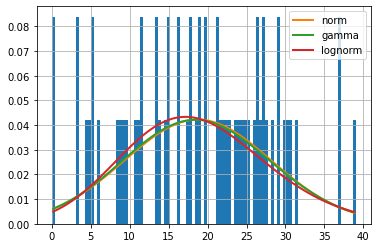

In [32]:
#test it runs
visualize_distributions(data=df, dv_col='cc_normalized_per_volume', distributions=["gamma","lognorm","norm"])

## Main function

In [40]:
def compute_assumptions(data: pd.DataFrame, dv_col: str, iv_col: str, stat_results) -> Dict:
    stat_results = check_normality(data, dv_col, results = stat_results)
    #Make dataframes compatible for Levene's and Bartlett's test
    equal_variance_test(data, dv_col, iv_col, stat_results) #ensure the data is appended to stat_results
    return stat_results

In [41]:
stat_results = compute_assumptions(df, "cc_normalized_per_volume", "group_id", stat_results)

{'normal_distribution': {'test_statistic': 0.9805209636688232,
  'p-value': 0.43962615728378296,
  'bool': True},
 'fixed_effects_equal_varriance': {'test_statistic': 1.008462065676145,
  'p-value': 0.31527156257040106,
  'bool': True}}

Model below is a continuation to deal with moddeling

In [ ]:
def run_a_model(data: pd.DataFrame, dv_col: str, iv_col: str, subject: str, distribution_type: Optional[str]=None) -> Dict:
    
    if (stat_results['fixed_effects_equal_varriance']['bool'] == True) AND (stat_results['normal_distribution']['bool'] == True):
        #Run LM() from R
    
    elif (stat_results['fixed_effects_equal_varriance']['bool'] == False) AND (stat_results['normal_distribution']['bool'] == True):
        #Run LMER() from R
        
    elif (stat_results['fixed_effects_equal_varriance']['bool'] == True) AND (stat_results['normal_distribution']['bool'] == False): 
        #if we have equal varriance & no normal distribution
        
        #GLM can only handle gamma, inverse gausian or normal
        visualize_distributions(data=df, dv_col='cc_normalized_per_volume', distributions=["gamma","invgauss","norm"])
        print("Your data can be used in a generlized linear model. Please select the name of the distribution that matches your data. If none, please note none.")
        #make an entery in stat_results['GLM_distribution']
        if stat_results['GLM_distribution'] != 'none':
            #run GLM with that distribution 
        #if we have equal varriance in fixed effects and have determined that no GLM distribution will work
        if: stat_results['GLM_distribution'] == 'none': #if GLM won't work 
            non_par_equal_var(data, dv_col, iv_col) #run non-parametric with non-agregated data
        else: print("An error has occured, please restart the function.")
            
        #in cases there there is no equal varriance
    elif (stat_results['fixed_effects_equal_varriance']['bool'] == False) AND (stat_results['normal_distribution']['bool'] == False):
        #if we have no equal varriance & no normal distribution
        
        #run GLMM - can only handle gamma, lognorm, norm
        visualize_distributions(data=df, dv_col='cc_normalized_per_volume', distributions=["gamma","lognorm","norm"])
        print("Your data can be used in a generlized linear mixed effects model. Please select the name of the distribution that matches your data. If none, please note none.")
        #make an entery in stat_results['GLMM_distribution']
        if stat_results['GLMM_distribution'] != 'none'
            #Run GLMER with that distribution
        if: stat_results['GLMM_distribution'] == 'none': #if GLMM won't work
            non_par_inequal_var(data, dv_col, iv_col, subject) #run non-parametric with agregated data
        else: print("An error has occured, please restart the function.")
    
    else: print("Values for stat_results might not be present. Please run check_assumptions()")

### Plotting Normality - used on existing model

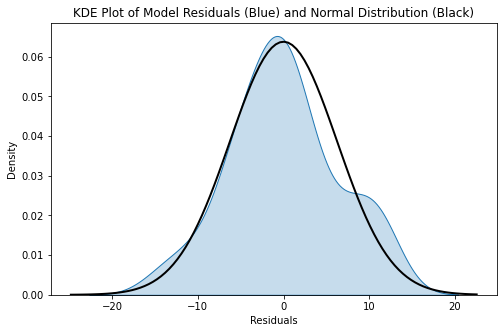

In [50]:
#2 types of normality plots
#kde_kws = {"shade" : True, "lw": 1}
fig = plt.figure(figsize=(8,5), facecolor='white')
ax = fig.add_subplot()
sns.kdeplot(model.resid, fill=True, ax=ax)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = norm.fit(model.resid)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

#sns.kdeplot(normal_dist, color = 'k', ax=ax)

plt.title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
plt.xlabel("Residuals")
plt.show()

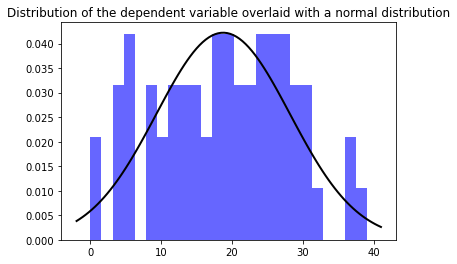

In [13]:
#h = sns.displot(df, x="cc_normalized_per_volume", kind="kde")
#df_normal = np.random.normal(statistics.mean(df['cc_normalized_per_volume']),statistics.stdev(df['cc_normalized_per_volume']),61)
df_hist = df['cc_normalized_per_volume']
mu, std = norm.fit(df_hist)
plt.hist(df_hist, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Distribution of the dependent variable overlaid with a normal distribution".format(mu, std)
plt.title(title)
  
plt.show()

#Problem: the histogram doesn't seem to represent our data - figure out why when you have time
#def map_pdf(x, **kwargs):
#    mu, std = scipy.stats.norm.fit(x)
#    x0, x1 = p1.axes[0][0].get_xlim()  # axes for p1 is required to determine x_pdf
#    x_pdf = np.linspace(x0, x1, 100)
#    y_pdf = scipy.stats.norm.pdf(x_pdf, mu, std)
#    plt.plot(x_pdf, y_pdf, c='r')


#p1 = sns.displot(data=df_hist, x=df_hist['cc_normalized_per_volume'], kind='hist', bins=40, stat='density')
#p1.map(map_pdf, 'cc_normalized_per_volume')

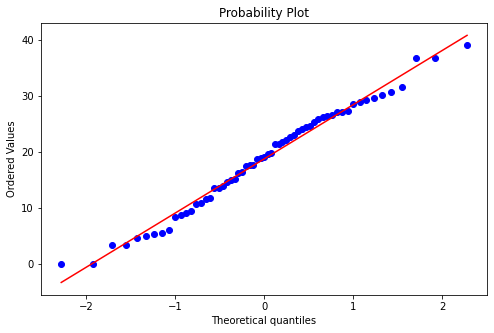

In [51]:
fig = plt.figure(figsize=(8,5), facecolor='white')
ax = fig.add_subplot()
ax = scipy.stats.probplot(df['cc_normalized_per_volume'], dist="norm", plot=plt)
plt.show()

# Linearity
To determine if we have linearity, the points should be symmetrically distributed around a horizontal line, with a roughly constant variance. 
Source: https://people.duke.edu/~rnau/testing.htm

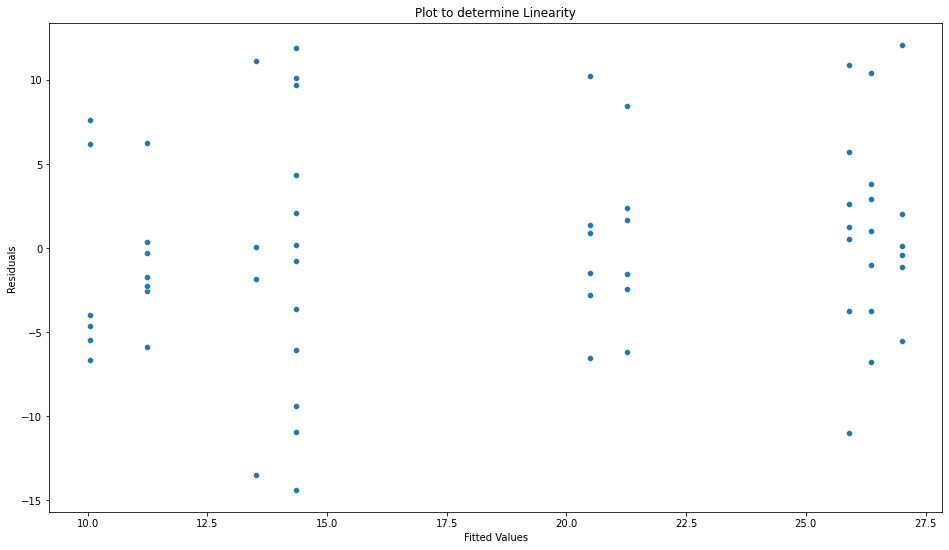

In [64]:
fig = plt.figure(figsize = (16, 9))
ax = sns.scatterplot(y = model.resid, x = model.fittedvalues)
ax.set_title("Plot to determine Linearity")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
plt.show()

### Outlier removal

In [68]:
df['cc_normalized_per_volume']

0      0.000000
1     18.729920
2      8.306840
3      4.944721
4     24.454311
        ...    
56    36.798276
57    28.516217
58    31.592163
59    22.159508
60    27.151992
Name: cc_normalized_per_volume, Length: 61, dtype: float64

In [78]:
df_filtered

,Unnamed: 0,file_id,group_id,subject_id,analyzed_area,total_planes,connected_components,cc_normalized_per_area,cc_normalized_per_volume
0,0,0,tg,#10_tg_old,1118784.0,8.0,0.0,0.000000,0.000000
1,1,1,tg,#10_tg_old,5697120.0,8.0,64.0,149.839362,18.729920
2,2,2,tg,#10_tg_old,6422816.0,8.0,32.0,66.454716,8.306840
3,3,3,tg,#10_tg_old,5394976.0,8.0,16.0,39.557768,4.944721
4,4,4,tg,#10_tg_old,4181696.0,9.0,69.0,220.088800,24.454311
...,...,...,...,...,...,...,...,...,...
56,56,59,wt,#9_wt_old,7410528.0,9.0,184.0,331.184482,36.798276
57,57,60,wt,#9_wt_old,7109728.0,10.0,152.0,285.162170,28.516217
58,58,61,wt,#9_wt_old,5770116.0,9.0,123.0,284.329471,31.592163
59,59,62,wt,#9_wt_old,5751712.0,9.0,86.0,199.435575,22.159508


In [93]:
cutoff = 1.5*df['cc_normalized_per_volume'].std()
mean = df['cc_normalized_per_volume'].mean()
min_value, max_value = df['cc_normalized_per_volume'].min(), df['cc_normalized_per_volume'].max()

df_filtered = df[(df.cc_normalized_per_volume >= mean - cutoff) & (df.cc_normalized_per_volume <= mean + cutoff)]

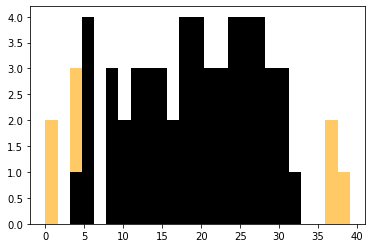

In [ ]:
plt.hist(df['cc_normalized_per_volume'], bins=25, range=(min_value, max_value), alpha=0.6, color='orange')
plt.hist(df_filtered['cc_normalized_per_volume'], bins=25, range=(min_value, max_value), color='black')
plt.show()

# Code graveyard 

In [ ]:
########## Already a function ###########

#def equal_variance_test(data: pd.DataFrame, dv_col: str, results: Dict) -> Dict:
#you where working on ensure this ran so you could make the function below run and then put it into the main function to ensure that equal varriance could be tested
    
    #Make dataframes compatible for Levene's and Bartlett's test
df_tg = df.loc[df['group_id'] == 'tg']
df_tg = df_tg.rename(columns={"cc_normalized_per_volume": "tg"})

df_wt = df.loc[df['group_id'] == 'wt']
df_wt = df_wt.rename(columns={"cc_normalized_per_volume": "wt"})

if stat_results['normal_distribution']['bool'] == False: #non-normal data
    stat, p_homo = levene(df_wt['wt'], df_tg['tg'])
    if p_homo >= 0.05:
        normal = True
        stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
    elif p_homo < 0.05:
        normal = False
        stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
elif stat_results['normal_distribution']['bool'] == True: #normal data
    stat, p_homo = bartlett(df_wt['wt'], df_tg['tg'])
    if p_homo >= 0.05:
        normal = True
        stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
    elif p_homo < 0.05:
        normal = False
        stat_results['fixed_effects_equal_varriance'] = {'test_statistic': stat, 'p-value': p_homo, 'bool': normal}
else: print('Normality not assessed yet. Please complete normality test before proceeding')

In [ ]:
####### useless --> R code used instead ######
import gpboost as gpb
gp_model = gpb.GPModel(group_data=df['subject_id'], likelihood="lognorm")
gp_model.fit(y='cc_normalized_per_volume', x = 'group_id')
gp_model.summary()

In [ ]:
###### Already in a function ########
from fitter import Fitter, get_common_distributions, get_distributions
f = Fitter(df['cc_normalized_per_volume'],
           distributions=['gamma',
                          'lognorm',
                          "norm"])
f.fit()
f.summary()

In [5]:
######## Pymer --> now R code ##########
#LM models
model = Lm("cc_normalized_per_volume ~ group_id", data=df)
print(model.fit())

filtered_subjects = []
for subject_id in df["subject_id"].unique():
    if df.loc[df["subject_id"]==subject_id].shape[0] == 6:
        filtered_subjects.append(df.loc[df["subject_id"]==subject_id].copy())
df_test = pd.concat(filtered_subjects)
df_test["subject_id"].value_counts()

model = Lmer("cc_normalized_per_volume ~ group_id + (1|subject_id)", data=df_test)
print(model.fit())

#error indicates I'm specifying too many columns (7), but I'm only using 2-3

Formula: cc_normalized_per_volume~group_id

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 61	 R^2: 0.000	 R^2_adj: -0.017

Log-likelihood: -223.555 	 AIC: 451.111	 BIC: 455.332

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val  Sig
Intercept         18.846  15.336   22.356  1.754  59  10.744  0.000  ***
group_id[T.wt]    -0.194  -5.117    4.730  2.461  59  -0.079  0.937     


In [ ]:
### Funtion for GLM (acually functional) --->  now in R ##########

df.loc[df['group_id'] == 'wt', 'group_id'] = -1
df.loc[df['group_id'] == 'tg', 'group_id'] = 1
df['group_id'] = pd.Categorical(df['group_id'])
df['cc_normalized_per_volume']

#make GLM run - endo = DV, exo = IDV
glm = sm.GLM(df['cc_normalized_per_volume'], df['group_id'], family=sm.families.Gaussian()) #supports Gamma, InverseGaussian, Gaussian
res = glm.fit()
print(res.summary())

In [ ]:
####### retired function - now using compute_statistics #######

# Example how the bigger picture could look like
#Note: make dict a global varribale and append for each function?
#removed from compute_statistics to make run: Dictdistribution_type: Optional[str]=None
def compute_statistics(data: pd.DataFrame, dv_col: str, iv_col: str, stat_results) -> Dict:
    stat_results = check_normality(data=df, dv_col='cc_normalized_per_volume', results = stat_results)
    if stat_results['normal_distribution']['bool']:
        model = create_a_mixed_linear_model(data = df, dv_col = 'cc_normalized_per_volume', fixed_effects_col = 'group_id', random_effects_col = 'subject_id')
        return model, stat_results
    #else:
        #Visualize the equaliy between the different groups
       # print("Normality could not be assumed. To determine which statistical model to use, please select if the varriance between different the different groups is equal")
       # plot_fixed_effect_varriance(data = df, dv_col = 'cc_normalized_per_volume', fixed_effects_col = 'group_id', random_effects_col = 'subject_id')
        #exit to make the user decide if varriance is equal and somehow note that in the results file. Note as 'fixed_effects_equal_varriance'
        # exit if distribution_type == None:
            # exit
        # if defined: adjusted_model = create_adjusted_model(data, distribution_type
        
        #ALTERNATIVELY
    else:
        #Make dataframes compatible for Levene's and Bartlett's test
        equal_variance_test(data, dv_col, iv_col, stat_results) #ensure the data is appended to stat_results
        return stat_results

In [ ]:
###### checking that data can be aggregated for non-parametic function - now implemented in function #####
#Aggregvate the data across subjects
df_nonpar = df.groupby(['subject_id', 'group_id'], as_index=False)['cc_normalized_per_volume'].mean()
#run non-par model
kruskal(data=df_nonpar, dv='cc_normalized_per_volume', between='group_id')

In [ ]:
### create function for LMER --> R code will replce ###

from statsmodels.regression.mixed_linear_model import MixedLMResultsWrapper

def create_a_mixed_linear_model(data: pd.DataFrame, dv_col: str, fixed_effects_col: str, random_effects_col: str) -> MixedLMResultsWrapper:
    return smf.mixedlm(f"{dv_col} ~ {fixed_effects_col}", data, groups = random_effects_col).fit()

In [ ]:
#Check it's running before putting it into the model --> now uses R code
model = smf.mixedlm("cc_normalized_per_volume ~ group_id", df, groups = "subject_id").fit()
model.summary()

In [ ]:
### Homoscedasticity loop based on normality - non-model related --> now used in equal_varriance_test

#Make dataframes compatible for Levene's and Bartlett's test
df_tg = df.loc[df['group_id'] == 'tg']
df_tg = df_tg.rename(columns={"cc_normalized_per_volume": "tg"})

df_wt = df.loc[df['group_id'] == 'wt']
df_wt = df_wt.rename(columns={"cc_normalized_per_volume": "wt"})

### Homoscedasticity loop based on normality - non-model related
stat, p_norm = shapiro(df['cc_normalized_per_volume'])
if p_norm >= 0.05:
    print("Normality can be assumed, running Bartlett's test")
    stat, p_homo = levene(df_wt['wt'], df_tg['tg'])
    if p_homo >= 0.05:
        print ("Homoscedasticity is not violated. P-value for Bartlett's test was {}".format(p_homo))
    elif p_homo < 0.05:
        print("Homoscedasticity is violated. P-value for Bartlett's test was {}. Consider running data transformations".format(p_homo))
else:
    print("WARNING: Normality is violated, running Levene's test")
    stat, p_homo = levene(df_wt['wt'], df_tg['tg'])
    if p_homo >= 0.05:
        print ("Homoscedasticity is not violated. P-value for Levene's test was {}".format(p_homo))
    elif p_homo < 0.05:
        print("Homoscedasticity is violated. P-value for Levene's test was {}".format(p_homo))
        

#### Visualizing Homoscedasticity - model related
Generally, if the ratio of the largest variance to the smallest variance is 1.5 or below, the data is homoscedastic.
Simply put, homoscedasticity means “having the same scatter.” For it to exist in a set of data, the points must be about the same distance from the line.
Source: https://www.statisticshowto.com/homoscedasticity/
Code source: https://www.pythonfordatascience.org/mixed-effects-regression-python/

In [ ]:
# plots for homoscasedesity - now in equal varriance function

fig = plt.figure(figsize = (16, 9))
ax = sns.scatterplot(y = model.resid, x = model.fittedvalues)
ax.set_title("Plot to determine homoscedasticity")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
plt.show()

fig = plt.figure(figsize = (16, 9))
ax = sns.stripplot(x = model.model.groups, y = model.resid, color='k')
ax = sns.violinplot(x = model.model.groups, y = model.resid)
ax.set_title("Distribution of Residuals for Each Subject")
ax.set_ylabel("Residuals")
ax.set_xlabel("Subject")
plt.show()

In [ ]:
######## extra fitter stuff not used in the code ######

#figure out which method is best based on the available criteria
f.get_best(method = 'aic')

#get parameters for a certain function - not noted what they mean
f.fitted_param['gamma']

#datapoints for the probability density function
f.fitted_pdf['gamma']

In [ ]:
# Generlized linear mixed effects model --> now R code is used

#inserted code chunk to deal with later
gp_model = gpb.GPModel(group_data=group_data, likelihood="binary")
gp_model.fit(y=y, X=X)
gp_model.summary()

#p-values
gp_model = gpb.GPModel(group_data=group, likelihood="binary")
gp_model.fit(y=y, X=X, params={“std_dev”: True})
coefs = gp_model.get_coef()
z_values = coefs[0] / coefs[1]
p_values = 2 * stats.norm.cdf(-np.abs(z_values))
print(p_values) # show p-values

#predictions
pred = gp_model.predict(X_pred=X_test, group_data_pred=group_test,
                        predict_var=True, predict_response=False)
print(pred['mu'])  # predicted latent mean
print(pred['var']) # predicted latent variance

group_data_pred is a matrix or vector with categorical grouping variable(s) for which predictions are made

X_pred is a matrix with fixed effects covariate data for which predictions are made

predict_var (boolean) indicates whether predictive variances should be calculated in addition to the mean

predict_response (boolean) indicates whether the response y or the latent Xb + Zu should be predicted. I.e., the random effects part is also predicted. If group_data_pred contains new, unobserved categories, the corresponding random effects predictions will be 0.